<div style="padding: 30px 60px; border: 5px skyblue solid; border-radius: 30px; max-width: 600px; font-size: 2rem; line-height: 3rem; color: black; font-family: sans-serif;">

  <div style="font-size: 1.5rem; font-weight: 200;">[CM3070] Final Project - BSc CS University of London</div>
  <div style="font-size: 1.5rem; font-weight: 500;">Deep Learning on Satellite Imagery</div>
  <div style="font-size: 2rem; color: dodgerblue; font-weight: bold;">by Arjun Bajaj</div>
</div>

# Building a Powerful Small Model for Microcontrollers

This notebook focuses on building small models which can be successfully deployed on the Raspberry Pi Pico Microcontroller. The Pico has only `256 KB` of RAM, and TensorFlow Lite requires the entire model to be loaded in memory while invoking inference. The size of the model is a stringent constraint that these models need to adhere to.

This notebook explores `Conv2D` and `SeparableConv2D` models. `SeparableConv2D` layers are powerful and lead to significantly less number of trainable parameters.

It was empirically established that `Conv2D` models need to be under `30k` parameters, and `SeparableConv2D` models need to be under `20k` parameters, to be able to run on the Pico. Hence, this notebook aims to achieve high accuracy models which fit in those constraints. Even if models are below the number of parameters prescribed, they may still fail at any stage from loading to invoking inference due to various reasons, such as requiring a larger tensor area than available. Hence, this section was conducted with a continuous trial-and-error feedback loop.

It is not possible to achieve high accuracies within 20 epochs with such small models after establishing good architectures. Hence, the models will be trained for much longer in this notebook. Along with all these changes, `Dropout` layers, changes to the learning rate, regularizers, and residual networks will be evaluated.

In [1]:
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from core import load_eurosat, compile_and_train_model

In [3]:
dataset = load_eurosat()

Found 21600 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.


# Small Conv2D Model

This model has only `29k` parameters and a `Dropout` layer. The learning rate is also 5 times higher than the default. When trained for 30 epochs, it gives an accuracy of `87.3%`, which is quite high considering only much bigger models were able to beat this accuracy.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                       

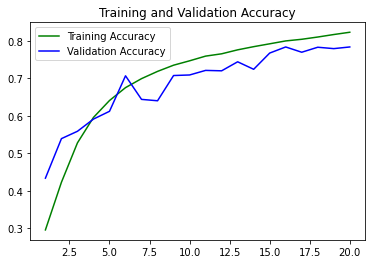

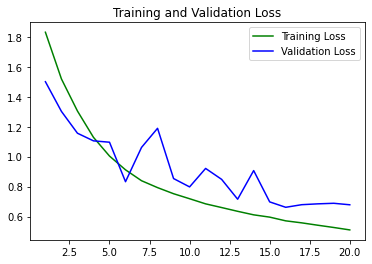

43/43 [==============================] - 1s 13ms/step - loss: 0.6616 - accuracy: 0.7841

Trained for 20 epochs in 2m46s.
Highest Validation Accuracy: 78.41%


In [6]:
def model_1():
  inputs = keras.Input(shape=(64, 64, 3))
  x = inputs
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()

  compile_and_train_model(
    model, 'small_conv2d', dataset,
    epochs=20, early_stopping=False,
    learning_rate=0.002
  )

model_1()

# A model with `SeperableConv2D`

This model is implemented using `3 SeperableConv2D` layers. The first `Conv2D` layer is retained, as the channels of colours (RGB) are highly related to each other. However, after that, _Depthwise Separable Convolution_ can be applied to speed up training, reduce the number of trainable parameters, and improve accuracy. This model achieves an accuracy of `89.89%` in `30` epochs and has only `24k` parameters.

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_12 (Separa  (None, 29, 29, 64)       2400      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 64)       0   

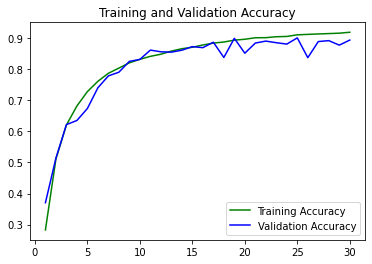

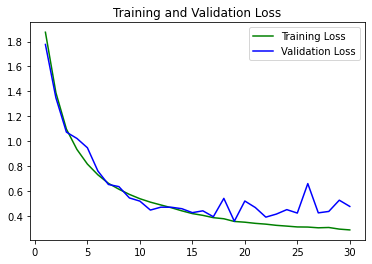

43/43 [==============================] - 1s 20ms/step - loss: 0.3591 - accuracy: 0.8989

Trained for 30 epochs in 6m45s.
Highest Validation Accuracy: 89.89%


In [13]:
def model_2():
  conv_reg = {'kernel_regularizer': keras.regularizers.L2(0.00001)}
  dense_reg = {'kernel_regularizer': keras.regularizers.L2(0.01)}

  inputs = keras.Input(shape=(64, 64, 3))
  x = inputs
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", **conv_reg)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=64, kernel_size=3, activation="relu", **conv_reg)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=96, kernel_size=3, activation="relu", **conv_reg)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu", **conv_reg)(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.25)(x)
  outputs = layers.Dense(10, activation="softmax", **dense_reg)(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()

  compile_and_train_model(
    model, 'small_sepconv2d', dataset,
    epochs=30, early_stopping=False, learning_rate=0.005
  )

model_2()

# ConvNet with Residuals

This model uses Residuals and `SeparableConv2D` layers along with `Conv2D` residual layers. The resulting model is smaller than the one above, but also achieves lesser accuracy at `92.30%`.


Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_64 (Rescaling)       (None, 64, 64, 3)    0           ['input_65[0][0]']               
                                                                                                  
 conv2d_228 (Conv2D)            (None, 64, 64, 32)   864         ['rescaling_64[0][0]']           
                                                                                                  
 batch_normalization_157 (Batch  (None, 64, 64, 32)  128         ['conv2d_228[0][0]']             
 Normalization)                                                                            

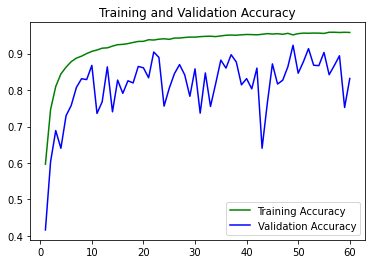

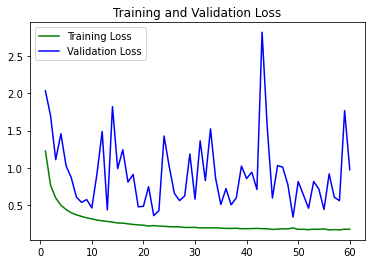

43/43 [==============================] - 2s 31ms/step - loss: 0.3395 - accuracy: 0.9230

Trained for 60 epochs in 27m54s.
Highest Validation Accuracy: 92.30%


In [69]:
def model_2():
  conv_reg = {'kernel_regularizer': keras.regularizers.L2(0.00001)}
  dense_reg = {'kernel_regularizer': keras.regularizers.L2(0.015)}

  inputs = keras.Input(shape=(64, 64, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, padding="same", use_bias=False, **conv_reg)(x)

  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(32, 1, strides=2, padding="same", use_bias=False, **conv_reg)(residual)
  x = layers.add([x, residual])

  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(32, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(32, 1, strides=2, padding="same", use_bias=False, **conv_reg)(residual)
  x = layers.add([x, residual])

  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(64, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(64, 1, strides=2, padding="same", use_bias=False, **conv_reg)(residual)
  x = layers.add([x, residual])

  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(64, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(64, 1, strides=2, padding="same", use_bias=False, **conv_reg)(residual)
  x = layers.add([x, residual])

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.25)(x)
  outputs = layers.Dense(10, activation="softmax", **dense_reg)(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()

  compile_and_train_model(
    model, 'small_sepconv2d_2', dataset,
    epochs=60, early_stopping=False, learning_rate=0.005
  )

model_2()

This model achieves the highest accuracy yet, in only 60 epochs. However, using Residuals is not an option for the Pico microcontroller.

The following error message is printed when trying to initialize this model's `TensorFlow Lite` converted version:
```
Initializing Tensorflow Lite: Model Loaded, Arena size is too small for all buffers. Needed 393216 but only 157344 was available.
```

The Pico only has `256 KB` of RAM, but running this model requires at least `384 KB` of RAM just to store the model and buffers for the input and output. More RAM would be required to run the rest of the code.

# A Small Model that runs on the Pico

Given the issues above, a simpler model architecture is required; one that doesn't use residuals or batch normalization. Such a model requires training for more epochs to reach a high accuracy. However, as it is simpler, each epoch takes less time to complete too. This model reaches an accuracy of `91.33%` after training for `125` epochs in `30` minutes. Overall, this model is small enough to run on the Pico, and has one of the highest accuracies yet of any model established in this project.

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_14 (Separa  (None, 29, 29, 64)       2400      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0   

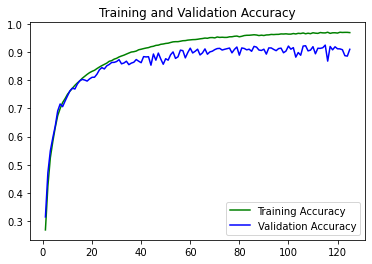

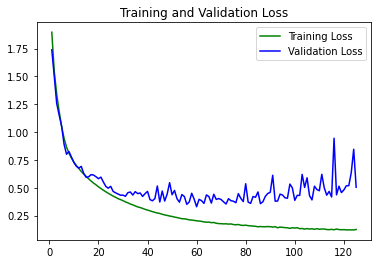

43/43 [==============================] - 1s 17ms/step - loss: 0.3289 - accuracy: 0.9133

Trained for 125 epochs in 30m30s.
Highest Validation Accuracy: 91.33%


In [11]:
def final_model():
  conv_reg = {'kernel_regularizer': keras.regularizers.L2(0.00001)}
  sconv_reg = {'bias_regularizer': keras.regularizers.L2(0.00001)}
  dense_reg = {'kernel_regularizer': keras.regularizers.L2(0.01)}

  inputs = keras.Input(shape=(64, 64, 3))
  x = inputs
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", **conv_reg)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=64, kernel_size=3, activation="relu", **sconv_reg)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=64, kernel_size=3, activation="relu", **sconv_reg)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu", **sconv_reg)(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.25)(x)
  outputs = layers.Dense(10, activation="softmax", **dense_reg)(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()

  compile_and_train_model(
    model, 'eurosat', dataset,
    epochs=125, early_stopping=False, learning_rate=0.002
  )

  # Copy the trained model to the artifacts directory
  shutil.copyfile('../models/eurosat.keras', '../artifacts/eurosat.keras')

final_model()

# Results

This notebook successfully uses techniques explored in the previous notebook to build and train high accuracy models with few trainable parameters, capable of running on the Raspberry Pi Pico microcontroller.

The next notebook focuses on taking the final Keras model and converting it into the TensorFlow Lite Format.

----